In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [4]:
# Define the file path
file_path = r"C:\Users\skosloff\Documents\Mean-Variance Analysis\BR MV Data 2.xlsx"

# Load the Excel file
# If the file has multiple sheets, specify the sheet name or index
retvol = pd.read_excel(file_path, sheet_name='RetVol')  
corr = pd.read_excel(file_path, sheet_name='Corr')  


# Drop columns
retvol.drop(retvol.columns[[0, 1, 3]], axis=1, inplace=True)

# Set the second row as the column headers
retvol.columns = retvol.iloc[1]
retvol = retvol[2:]  

# Drop columns
corr.drop(corr.columns[[0,1]], axis=1, inplace=True)

# Set the second row as the column headers
corr.columns = corr.iloc[1]
corr = corr[2:]  

# Set index of corr
corr.set_index('Asset', inplace=True)

# Reorder correlation matrix to match retvol
new_order = [
    'U.S. cash', 
    'U.S. government bonds (all maturities)', 
    'U.S. large cap equities', 
    'Hedge funds (global)', 
    'U.S. credit (all maturities)', 
    'U.S. private equity (buyout)', 
    'U.S. small cap equities', 
    'Global infrastructure equity', 
    'Real estate mezzanine debt', 
    'U.S. core real estate'
]

# Reindex the correlation matrix
corr = corr.reindex(index=new_order, columns=new_order)

C:\Users\skosloff\AppData\Local\anaconda3\envs\PortOpt\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\skosloff\AppData\Local\anaconda3\envs\PortOpt\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [5]:
# Define expected returns, correlation matrix, and variances for 10 assets
expected_returns = retvol['Expected Return (10yr)'].values
correlations = corr.values
variances = retvol['Volatility'].values


# Convert to float
expected_returns = np.array(expected_returns, dtype=float)
variances = np.array(variances, dtype=float)
correlations = np.array(correlations, dtype=float)

# Convert variances to standard deviations
std_devs = np.sqrt(variances)

# Calculate covariance matrix from correlation matrix and variances
cov_matrix = np.diag(std_devs) @ corr @ np.diag(std_devs)

# Define the number of assets
n_assets = len(expected_returns)

Expected Returns

In [29]:
# Define the objective function to maximize expected return
def objective(weights):
    return -np.dot(weights, expected_returns)  # Negative because we maximize

# Define the constraints dictionary
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},     # Weights must sum to 1
    {'type': 'ineq', 'fun': lambda x: 0.10 - x[3]},  # HF allocation must be <= 10%
    {'type': 'ineq', 'fun': lambda x: 0.12 - np.sqrt(np.dot(x.T, np.dot(cov_matrix, x)))}  # Portfolio volatility <= X%
    #{'type': 'ineq', 'fun': lambda x: x[2] - 0.30} # Allocation to large cap equities must be >= 30%
]

# Initial guess
x0 = np.ones(n_assets) / n_assets

# Define bounds for the weights (between 0.01 and 0.40)
bounds = [(0.01, 0.6) for _ in range(n_assets)]

# Set max iterations in options
options = {
    'maxiter': 5000  # Set maximum number of iterations
}

# Solve the problem using SLSQP method
solution = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints, tol=1e-6, options=options)

# Output the optimized weights
optimized_weights = solution.x
print("Optimized Portfolio Weights:", optimized_weights)

# Calculate the expected return and volatility of the optimized portfolio
expected_portfolio_return = np.dot(optimized_weights, expected_returns)
expected_portfolio_volatility = np.sqrt(optimized_weights.T @ cov_matrix @ optimized_weights)

print("Expected Portfolio Return:", np.round(expected_portfolio_return * 100, 2))
print("Expected Portfolio Volatility:", np.round(expected_portfolio_volatility * 100, 2))


Optimized Portfolio Weights: [0.5720854  0.06677613 0.01       0.1        0.01       0.01
 0.01       0.20113848 0.01       0.01      ]
Expected Portfolio Return: 5.95
Expected Portfolio Volatility: 12.0


C:\Users\skosloff\AppData\Local\anaconda3\envs\PortOpt\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [30]:
solution.success

True

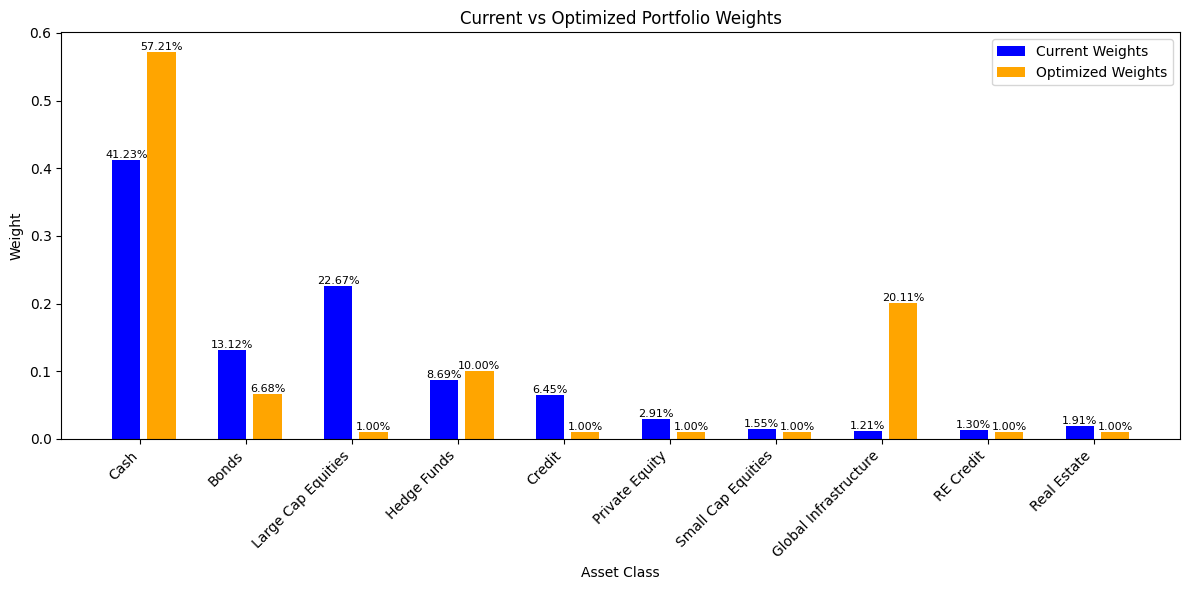

In [43]:
# Plot the optimized weights
asset_names = ['Cash', 'Bonds', 'Large Cap Equities', 'Hedge Funds', 'Credit', 'Private Equity', 'Small Cap Equities', 'Global Infrastructure', 'RE Credit', 'Real Estate']

current_weights = np.array([0.4123, 0.1312, 0.2267, 0.0869, 0.0645, 0.0291, 0.0155, 0.0121, 0.013, 0.0191])

# Asset names
asset_names = ['Cash', 'Bonds', 'Large Cap Equities', 'Hedge Funds', 'Credit', 'Private Equity', 'Small Cap Equities', 'Global Infrastructure', 'RE Credit', 'Real Estate']

# Create a range for the x-axis with larger space between asset classes
x_values = np.arange(len(optimized_weights)) * 3

# Plot the bar chart for the current weights
plt.figure(figsize=(12, 6))
bars_curr = plt.bar(x_values - 0.4, current_weights, width=0.8, label='Current Weights', color='blue')

# Overlay the bar chart for the optimized portfolio weights
bars_opt = plt.bar(x_values + 0.6, optimized_weights, width=0.8, label='Optimized Weights', color='orange')

plt.title('Current vs Optimized Portfolio Weights')
plt.xlabel('Asset Class')
plt.ylabel('Weight')
plt.xticks(x_values, asset_names, rotation=45, ha='right')

# Annotate each bar with the percentage value for current weights
for bar, weight in zip(bars_curr, current_weights):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{weight:.2%}', ha='center', va='bottom', fontsize=8)

# Annotate each bar with the percentage value for optimized weights
for bar, weight in zip(bars_opt, optimized_weights):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{weight:.2%}', ha='center', va='bottom', fontsize=8)


# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Sharpe

In [57]:
risk_free_rate = 0.0475
# Define the objective function to maximize Sharpe ratio (negative because we minimize)
def objective(weights):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Negative Sharpe ratio for minimization

# Initial guess
x0 = np.ones(n_assets) / n_assets

# Define the constraints dictionary
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},     # Weights must sum to 1
    {'type': 'ineq', 'fun': lambda x: 0.10 - x[3]},  # HF allocation must be <= 10%
    {'type': 'ineq', 'fun': lambda x: 0.20 - x[7]},  # "Global Infrastructure" allocation must be <= 40%
    {'type': 'ineq', 'fun': lambda x: 0.2 - np.sqrt(np.dot(x.T, np.dot(cov_matrix, x)))}  # Portfolio volatility <= X%
]

# Define bounds for the weights (between 0.01 and 0.40)
bounds = [(0.01, 0.6) for _ in range(n_assets)]

# Set max iterations in options
options = {
    'maxiter': 5000  # Set maximum number of iterations
}

# Solve the problem using SLSQP method
solution = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints, tol=1e-6, options=options)

# Output the optimized weights
optimized_weights = solution.x
print("Optimized Portfolio Weights:", optimized_weights)

# Calculate the expected return and volatility of the optimized portfolio
expected_portfolio_return = np.dot(optimized_weights, expected_returns)
expected_portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
sharpe_ratio = (expected_portfolio_return - risk_free_rate) / expected_portfolio_volatility

print("Expected Portfolio Return:", expected_portfolio_return)
print("Expected Portfolio Volatility:", expected_portfolio_volatility)
print("Sharpe Ratio:", sharpe_ratio)



Optimized Portfolio Weights: [0.32528584 0.14322855 0.01       0.1        0.01       0.18148561
 0.01       0.2        0.01       0.01      ]
Expected Portfolio Return: 0.07015174991219561
Expected Portfolio Volatility: 0.20000002325597097
Sharpe Ratio: 0.11325873639126863


In [58]:
solution.success

True

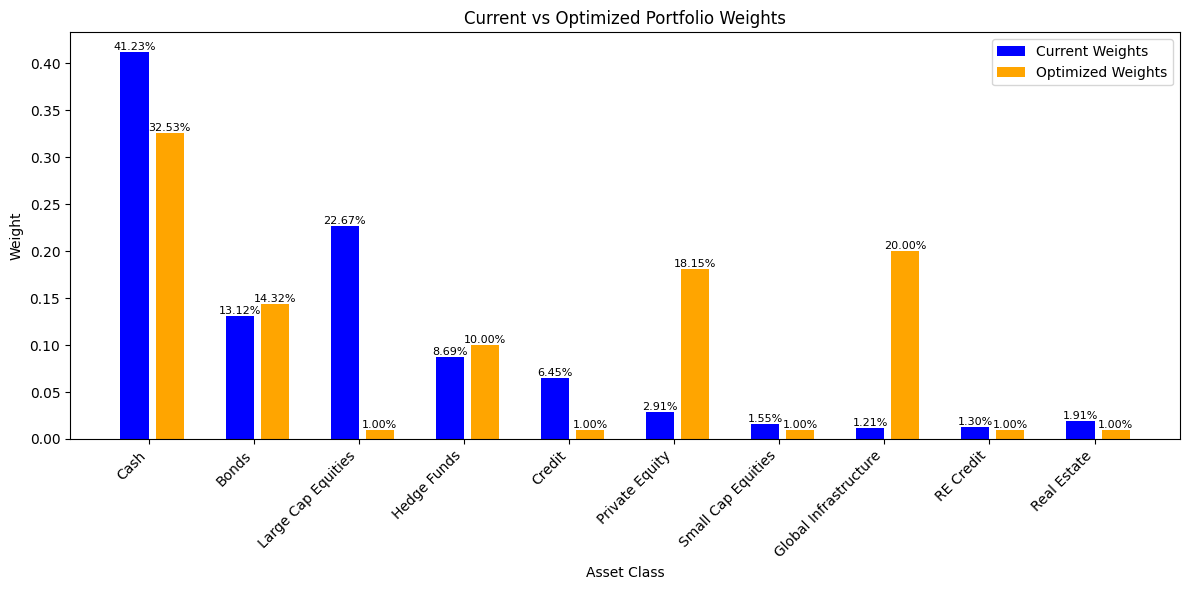

In [59]:
# Plot the optimized weights
asset_names = ['Cash', 'Bonds', 'Large Cap Equities', 'Hedge Funds', 'Credit', 'Private Equity', 'Small Cap Equities', 'Global Infrastructure', 'RE Credit', 'Real Estate']

current_weights = np.array([0.4123, 0.1312, 0.2267, 0.0869, 0.0645, 0.0291, 0.0155, 0.0121, 0.013, 0.0191])

# Asset names
asset_names = ['Cash', 'Bonds', 'Large Cap Equities', 'Hedge Funds', 'Credit', 'Private Equity', 'Small Cap Equities', 'Global Infrastructure', 'RE Credit', 'Real Estate']

# Create a range for the x-axis with larger space between asset classes
x_values = np.arange(len(optimized_weights)) * 3

# Plot the bar chart for the current weights
plt.figure(figsize=(12, 6))
bars_curr = plt.bar(x_values - 0.4, current_weights, width=0.8, label='Current Weights', color='blue')

# Overlay the bar chart for the optimized portfolio weights
bars_opt = plt.bar(x_values + 0.6, optimized_weights, width=0.8, label='Optimized Weights', color='orange')

plt.title('Current vs Optimized Portfolio Weights')
plt.xlabel('Asset Class')
plt.ylabel('Weight')
plt.xticks(x_values, asset_names, rotation=45, ha='right')

# Annotate each bar with the percentage value for current weights
for bar, weight in zip(bars_curr, current_weights):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{weight:.2%}', ha='center', va='bottom', fontsize=8)

# Annotate each bar with the percentage value for optimized weights
for bar, weight in zip(bars_opt, optimized_weights):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{weight:.2%}', ha='center', va='bottom', fontsize=8)


# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()